In [1]:
import pandas as pd
import altair as alt
import seaborn as sns
import numpy as np
import scipy as sp
import recommendations as rd

## 协作型过滤

### 搜集偏好

In [32]:
from imp import reload
reload(rd)

<module 'recommendations' from '/home/xashes/Workspace/fork/programming-collective-intelligence-code/chapter2/recommendations.py'>

In [33]:
critics = rd.critics.copy()
critics

,Lisa Rose,Gene Seymour,Michael Phillips,Claudia Puig,Mick LaSalle,Jack Matthews,Toby
Just My Luck,3.0,1.5,NaN,3.0,2.0,NaN,NaN
Lady in the Water,2.5,3.0,2.5,NaN,3.0,3.0,NaN
Snakes on a Plane,3.5,3.5,3.0,3.5,4.0,4.0,4.5
Superman Returns,3.5,5.0,3.5,4.0,3.0,5.0,4.0
The Night Listener,3.0,3.0,4.0,4.5,3.0,3.0,NaN
"You, Me and Dupree",2.5,3.5,NaN,2.5,2.0,3.5,1.0


In [4]:
critics_long_form = pd.melt(critics.T.reset_index(), id_vars=['index'], value_name='score', var_name='movie'
                           ).rename(columns={'index': 'person'})
critics_long_form.head()

,person,movie,score
0,Lisa Rose,Just My Luck,3.0
1,Gene Seymour,Just My Luck,1.5
2,Michael Phillips,Just My Luck,NaN
3,Claudia Puig,Just My Luck,3.0
4,Mick LaSalle,Just My Luck,2.0


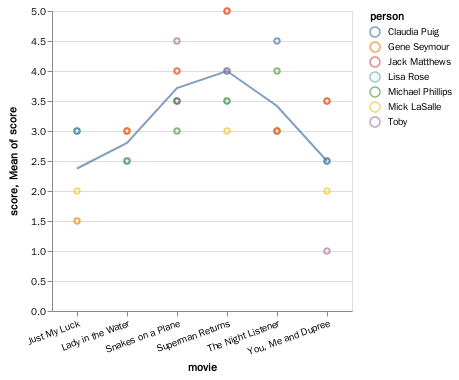

In [5]:
base = alt.Chart(critics_long_form).encode(
    alt.X('movie:N', axis=alt.Axis(labelAngle=-20))    
).properties(
    width=300
)
movie = base.mark_point().encode(
    alt.Y('score:Q'),
    color=alt.Color('person:N'),
    tooltip=['person', 'movie', 'score'],
)

line = base.mark_line(opacity=0.7).encode(
    alt.Y('mean(score):Q')
)
movie + line

### 寻找相近的用户

#### 计算相似度评价值的体系
    - 欧几里得距离
    - 皮尔逊相关度

##### Euclidean Distance Score
    以经过人们一致评价的物品作为坐标轴，然后将参与评价的人绘制到图上，并考查其彼此间的距离。
    下图显示了处于“偏好空间”中的人们的分布情况：

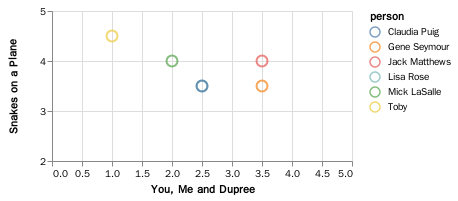

In [6]:
alt.Chart(critics.T.reset_index().rename(columns={'index':'person'})).mark_point(size=120).encode(
    alt.X('You, Me and Dupree', scale=alt.Scale(domain=[0, 5])),
    alt.Y('Snakes on a Plane', scale=alt.Scale(domain=[2, 5])),
    color='person:N',
    tooltip=['person']
).properties(width=300, height=150)

In [7]:
rd.sim_distance(critics, 'Lisa Rose', 'Gene Seymour')

0.29429805508554946

##### Pearson 相关系数
    判断两组数据与某一直线的拟合程度。在数据不是很规范（normalized）的时候，会倾向于给出更好的结果。
    其亦有修正“夸大分值（grade inflation）”的作用。这一行为是否是想要的结果，要取决于具体的应用场景。
    现成可用的函数:
```
df.corr(method='pearson')
scipy.stats.pearsonr(arr1, arr2)
```

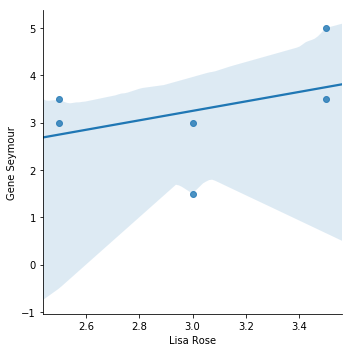

In [176]:
sns.lmplot('Lisa Rose', 'Gene Seymour', data=critics)

In [8]:
critics.corr(method='pearson')

,Lisa Rose,Gene Seymour,Michael Phillips,Claudia Puig,Mick LaSalle,Jack Matthews,Toby
Lisa Rose,1.000000,0.396059,0.404520,0.566947,0.594089,0.747018,0.991241
Gene Seymour,0.396059,1.000000,0.204598,0.314970,0.411765,0.963796,0.381246
Michael Phillips,0.404520,0.204598,1.000000,1.000000,-0.258199,0.134840,-1.000000
Claudia Puig,0.566947,0.314970,1.000000,1.000000,0.566947,0.028571,0.893405
Mick LaSalle,0.594089,0.411765,-0.258199,0.566947,1.000000,0.211289,0.924473
Jack Matthews,0.747018,0.963796,0.134840,0.028571,0.211289,1.000000,0.662849
Toby,0.991241,0.381246,-1.000000,0.893405,0.924473,0.662849,1.000000


In [9]:
sp.stats.pearsonr(critics['Lisa Rose'], critics['Gene Seymour'])

(0.39605901719066977, 0.43697492654267506)

In [10]:
rd.sim_pearson(critics, 'Lisa Rose', 'Jack Matthews')

0.747017880833996

### Ranking the Critics

In [14]:
rd.topMatches(critics, 'Toby', n=3)

[(0.9912407071619304, 'Lisa Rose'),
 (0.924473451641905, 'Mick LaSalle'),
 (0.8934051474415644, 'Claudia Puig')]

### Racommending Items

In [84]:
df = critics.T
df

,Just My Luck,Lady in the Water,Snakes on a Plane,Superman Returns,The Night Listener,"You, Me and Dupree"
Lisa Rose,3.0,2.5,3.5,3.5,3.0,2.5
Gene Seymour,1.5,3.0,3.5,5.0,3.0,3.5
Michael Phillips,NaN,2.5,3.0,3.5,4.0,NaN
Claudia Puig,3.0,NaN,3.5,4.0,4.5,2.5
Mick LaSalle,2.0,3.0,4.0,3.0,3.0,2.0
Jack Matthews,NaN,3.0,4.0,5.0,3.0,3.5
Toby,NaN,NaN,4.5,4.0,NaN,1.0


In [85]:
similarity = critics.corr().Toby
df = df.apply(lambda col: col * similarity)
df['similarity'] = similarity
df = df.drop('Toby')
df

,Just My Luck,Lady in the Water,Snakes on a Plane,Superman Returns,The Night Listener,"You, Me and Dupree",similarity
Lisa Rose,2.973722,2.478102,3.469342,3.469342,2.973722,2.478102,0.991241
Gene Seymour,0.571870,1.143739,1.334362,1.906232,1.143739,1.334362,0.381246
Michael Phillips,NaN,-2.500000,-3.000000,-3.500000,-4.000000,NaN,-1.000000
Claudia Puig,2.680215,NaN,3.126918,3.573621,4.020323,2.233513,0.893405
Mick LaSalle,1.848947,2.773420,3.697894,2.773420,2.773420,1.848947,0.924473
Jack Matthews,NaN,1.988547,2.651396,3.314245,1.988547,2.319971,0.662849


In [86]:
movie = df.loc[:, ['Just My Luck', 'similarity']].dropna()
movie.sum()

Just My Luck    8.074754
similarity      3.190366
dtype: float64

In [87]:
ranking = movie.sum()['Just My Luck'] / movie.sum()['similarity']
ranking

2.5309807037655645